In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [81]:
df = pd.read_csv('complete_df_with_predictions.csv')

In [82]:
df

,Unnamed: 0,decile3,ID,decile1,race,lsat,ugpa,zfygpa,grad,zgpa,...,race1_hisp,race1_other,race1_white,pass_bar_lr,pass_bar_lr_weighted,pass_bar_lr_best,pass_bar_rf,pass_bar_xgb,pass_bar_xgb_r,race1
0,0,10.0,2,10.0,7.0,44.0,3.5,1.33,1,1.88,...,False,False,True,1,1,1,1,1,1,white
1,1,4.0,3,5.0,7.0,29.0,3.5,-0.11,1,-0.57,...,False,False,True,1,0,1,1,1,0,white
2,2,2.0,36,3.0,7.0,36.0,3.5,-0.64,1,-1.12,...,False,False,True,1,0,1,0,0,0,white
3,3,4.0,52,7.0,7.0,39.0,3.5,0.34,1,-0.49,...,False,False,True,1,1,1,1,1,1,white
4,4,8.0,55,9.0,7.0,48.0,3.5,1.02,1,0.76,...,False,False,True,1,1,1,1,1,1,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,22402,1.0,10695,3.0,3.0,26.5,1.8,-0.58,1,-1.49,...,False,False,False,0,0,0,0,0,0,black
22068,22403,1.0,19642,3.0,3.0,19.7,1.8,-0.64,1,-1.36,...,False,False,False,0,0,0,0,0,0,black
22069,22404,8.0,24704,7.0,3.0,36.0,1.8,0.41,1,0.80,...,False,False,False,1,1,1,1,1,1,black
22070,22405,10.0,10000,10.0,7.0,44.0,1.5,1.88,1,1.42,...,False,False,True,1,1,1,1,1,1,white


In [83]:
df.columns

Index(['Unnamed: 0', 'decile3', 'ID', 'decile1', 'race', 'lsat', 'ugpa',
       'zfygpa', 'grad', 'zgpa', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr',
       'fam_inc', 'parttime', 'male', 'race2', 'pass_bar', 'bar', 'tier',
       'academic_career', 'race1_black', 'race1_hisp', 'race1_other',
       'race1_white', 'pass_bar_lr', 'pass_bar_lr_weighted',
       'pass_bar_lr_best', 'pass_bar_rf', 'pass_bar_xgb', 'pass_bar_xgb_r',
       'race1'],
      dtype='object')

In [84]:
predicted_cols = ['pass_bar_lr', 'pass_bar_lr_weighted',
       'pass_bar_lr_best', 'pass_bar_rf', 'pass_bar_xgb', 'pass_bar_xgb_r']

In [85]:
df = df.drop(columns=predicted_cols)
df.columns

Index(['Unnamed: 0', 'decile3', 'ID', 'decile1', 'race', 'lsat', 'ugpa',
       'zfygpa', 'grad', 'zgpa', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr',
       'fam_inc', 'parttime', 'male', 'race2', 'pass_bar', 'bar', 'tier',
       'academic_career', 'race1_black', 'race1_hisp', 'race1_other',
       'race1_white', 'race1'],
      dtype='object')

The variables to check are: 
- race (encoded through one-hot encoding)
- family income group 
- school tier

The models we are deploying are: 
- Weighted Logistic Regression with Grid Search
- Random Forest
- XGBoost R 

## Divide in train and test

In [86]:
from sklearn.calibration import LabelEncoder


race_enc = LabelEncoder()
df['race_encoded'] = race_enc.fit_transform(df['race1'])

In [87]:
race_encoding = dict(zip(race_enc.classes_, race_enc.transform(race_enc.classes_)))
print("Race encoding dictionary:", race_encoding)

Race encoding dictionary: {'asian': 0, 'black': 1, 'hisp': 2, 'other': 3, 'white': 4}


In [88]:
# Features we want to use
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'race_encoded']

# Target variable
target = 'pass_bar'

In [89]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = X_train.copy()
df_train[target] = y_train
df_test = X_test.copy()
df_test[target] = y_test

## Apply reweighing and run the model, to see parameters

In [90]:
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing

# Build StandardDataset from training data
dataset_train = StandardDataset(
    df_train,
    label_name='pass_bar',
    favorable_classes=[1],
    protected_attribute_names=['race_encoded', 'fam_inc', 'tier'],
    privileged_classes=[[4], [5], [6]]
)

RW = Reweighing(
    privileged_groups=[{'race_encoded': 4, 'fam_inc': 5, 'tier': 6}],
    unprivileged_groups=[
        {'race_encoded': r, 'fam_inc': i, 'tier': t}
        for r in set(df_train['race_encoded']) - {4}
        for i in set(df_train['fam_inc']) - {5}
        for t in set(df_train['tier']) - {6}
    ]
)

dataset_rw = RW.fit_transform(dataset_train)
df_train_rw = dataset_rw.convert_to_dataframe()[0]
weights_rw = dataset_rw.instance_weights

X_train_rw = df_train_rw.drop(columns=['pass_bar', 'race_encoded', 'fam_inc', 'tier'])
y_train_rw = df_train_rw['pass_bar']


In [91]:
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

ratio = np.sum(y_train_rw == 0) / np.sum(y_train_rw == 1)
xgb_rw_model = XGBClassifier(eval_metric='mlogloss', random_state=42, scale_pos_weight=ratio, reg_alpha=5, reg_lambda=5, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100)  
xgb_rw_model.fit(X_train_rw, y_train_rw, sample_weight=weights_rw)

# Predict on the **same test set**
X_test_aligned = df_test[X_train_rw.columns]
y_pred_rw = xgb_rw_model.predict(X_test_aligned)

print(confusion_matrix(y_test, y_pred_rw))
print(classification_report(y_test, y_pred_rw))


[[ 184   43]
 [ 875 3313]]
              precision    recall  f1-score   support

           0       0.17      0.81      0.29       227
           1       0.99      0.79      0.88      4188

    accuracy                           0.79      4415
   macro avg       0.58      0.80      0.58      4415
weighted avg       0.95      0.79      0.85      4415



The results are in line with what was seen before. 

## Retrain on the whole reweighted dataset

In [92]:
df.dtypes

Unnamed: 0           int64
decile3            float64
ID                   int64
decile1            float64
race               float64
lsat               float64
ugpa               float64
zfygpa             float64
grad                 int64
zgpa               float64
bar1                 int64
bar1_yr            float64
bar2                 int64
bar2_yr            float64
fam_inc            float64
parttime           float64
male               float64
race2               object
pass_bar             int64
bar                 object
tier               float64
academic_career    float64
race1_black           bool
race1_hisp            bool
race1_other           bool
race1_white           bool
race1               object
race_encoded         int32
dtype: object

In [93]:
nokeep = ['bar', 'race2', 'race1']
keep = list(set(df.columns) - set(nokeep))
df_full = df[keep]
df_full.dtypes

race1_black           bool
lsat               float64
race1_white           bool
race               float64
pass_bar             int64
bar1                 int64
academic_career    float64
decile1            float64
race1_hisp            bool
bar2_yr            float64
ID                   int64
parttime           float64
ugpa               float64
bar2                 int64
race1_other           bool
tier               float64
male               float64
zfygpa             float64
bar1_yr            float64
race_encoded         int32
fam_inc            float64
zgpa               float64
grad                 int64
decile3            float64
Unnamed: 0           int64
dtype: object

In [94]:
# Recreate the full StandardDataset
dataset_full = StandardDataset(
    df_full,
    label_name='pass_bar',
    favorable_classes=[1],
    protected_attribute_names=['race_encoded', 'fam_inc', 'tier'],
    privileged_classes=[[4], [5], [6]]
)

# Apply reweighing to the full data
RW_full = Reweighing(
    privileged_groups=[{'race_encoded': 4, 'fam_inc': 5, 'tier': 6}],
    unprivileged_groups=[
        {'race_encoded': r, 'fam_inc': i, 'tier': t}
        for r in set(df['race_encoded']) - {4}
        for i in set(df['fam_inc']) - {5}
        for t in set(df['tier']) - {6}
    ]
)

dataset_full_rw = RW_full.fit_transform(dataset_full)
df_full_rw = dataset_full_rw.convert_to_dataframe()[0]
weights_full = dataset_full_rw.instance_weights


In [95]:
X_full_rw = df_full_rw.drop(columns=['pass_bar', 'race_encoded', 'fam_inc', 'tier'])
y_full_rw = df_full_rw['pass_bar']

In [96]:
ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
xgb_best_model_regul = XGBClassifier(eval_metric='mlogloss', random_state=42, scale_pos_weight=ratio, reg_alpha=5, reg_lambda=5, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=100)  
xgb_best_model_regul.fit(X_full_rw, y_full_rw) 
pass_bar_xgb_r_rw = xgb_best_model_regul.predict(X_full_rw)
df_full['pass_bar_xgb_r_rw'] = pass_bar_xgb_r_rw

C:\Users\annad\AppData\Local\Temp\ipykernel_16840\1356473432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['pass_bar_xgb_r_rw'] = pass_bar_xgb_r_rw


## Check bias

In [97]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

### Race

In [98]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = {}

df_full['race1'] = df['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_full[df_full['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_xgb_r_rw', 'race_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_xgb_r_rw', 'race_bin'])

    if df_numeric['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one race_bin present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_xgb_r_rw'],
        protected_attribute_names=['race_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'race_bin': 1}],
        unprivileged_groups=[{'race_bin': 0}]
    )

    results[group] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference()
    }

print(results)


C:\Users\annad\AppData\Local\Temp\ipykernel_16840\3139134377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['race1'] = df['race1'].str.lower().str.strip()


{'black': {'Disparate Impact': 0.8066434601672019, 'Statistical Parity Difference': -0.1869259843427462}, 'hisp': {'Disparate Impact': 0.9053574519262774, 'Statistical Parity Difference': -0.09149497335173884}, 'asian': {'Disparate Impact': 0.9540258125673858, 'Statistical Parity Difference': -0.04444520080691683}, 'other': {'Disparate Impact': 0.9268648122095939, 'Statistical Parity Difference': -0.07070289414381803}}


C:\Users\annad\AppData\Local\Temp\ipykernel_16840\3271686522.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

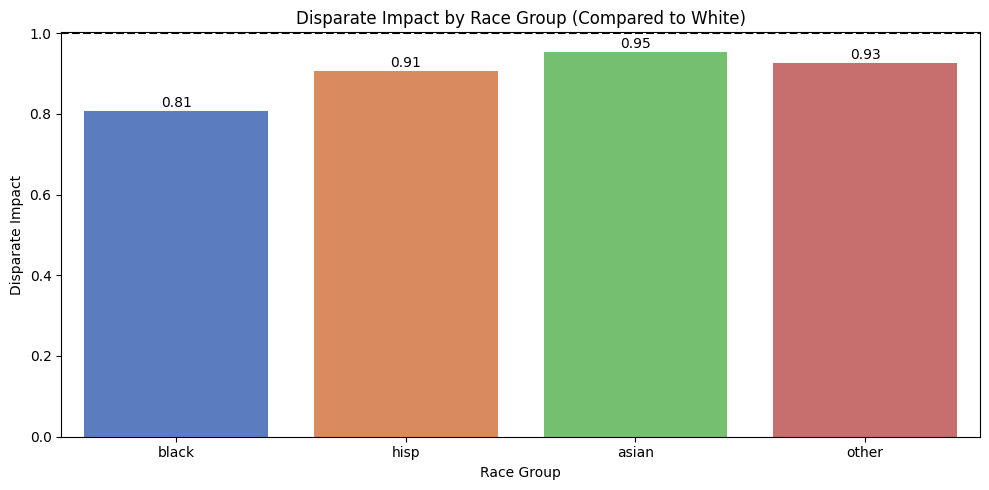

In [99]:
import seaborn as sns

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Race'})

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Race Group (Compared to White)")
plt.ylabel("Disparate Impact")
plt.xlabel("Race Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


### Family income

C:\Users\annad\AppData\Local\Temp\ipykernel_16840\2409773252.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

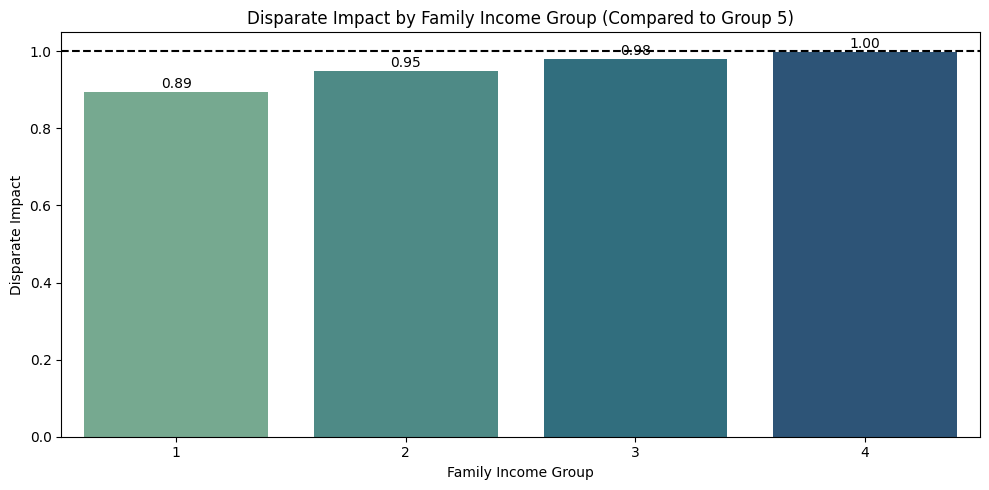

In [100]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = {}

df_full = df_full.dropna(subset=['fam_inc'])

for group in income_groups:
    df_temp = df_full[df_full['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar_xgb_r_rw', 'income_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar_xgb_r_rw', 'income_bin'])

    if df_numeric['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar_xgb_r_rw'],
        protected_attribute_names=['income_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'income_bin': 1}],  # high income (5)
        unprivileged_groups=[{'income_bin': 0}]  # current group
    )

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference()
    }

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Income Group'})
results_df = results_df.sort_values(by='Income Group')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Family Income Group (Compared to Group 5)")
plt.ylabel("Disparate Impact")
plt.xlabel("Family Income Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()
